In [1]:
%pylab inline
import numpy 
import scipy
import itertools
from umap import UMAP
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from collections import defaultdict as dd

numpy.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


In [2]:
experiments = numpy.loadtxt("/users/kofiamoah/data/search_ui/data/ENCODE_Tracks.txt", dtype=str, delimiter="\t")
celltypes = numpy.unique(experiments[:,0])
assays = numpy.unique(experiments[:,1])

experiments = numpy.array([(celltype, assay) for celltype, assay in itertools.product(celltypes, assays)])

raw_corr = numpy.load('/users/kofiamoah/data/search_ui/data/correlations_33600_600000.npz', )['arr_0']

In [3]:
expt_embedding = scipy.sparse.load_npz('/users/kofiamoah/data/search_ui/encode-ui-sandbox/data/embeddings/experiments_15nn.npz').toarray()

In [4]:
print(celltypes.shape)
print(assays.shape)
print(experiments.shape)
print(expt_embedding.shape)

print (experiments[:10,])
print (assays[:10,])
print (celltypes[:10,])
print (expt_embedding[:3,])

(400,)
(84,)
(33600, 2)
(33600, 33600)
[['J000' 'ATAC-seq_signal_p-value']
 ['J000' 'CAGE_minus_strand_signal_of_all_reads']
 ['J000' 'CAGE_plus_strand_signal_of_all_reads']
 ['J000' 'ChIP-seq_ATF3_signal_p-value']
 ['J000' 'ChIP-seq_BHLHE40_signal_p-value']
 ['J000' 'ChIP-seq_CEBPB_signal_p-value']
 ['J000' 'ChIP-seq_CHD2_signal_p-value']
 ['J000' 'ChIP-seq_CTCF_signal_p-value']
 ['J000' 'ChIP-seq_EGR1_signal_p-value']
 ['J000' 'ChIP-seq_ELF1_signal_p-value']]
['ATAC-seq_signal_p-value' 'CAGE_minus_strand_signal_of_all_reads'
 'CAGE_plus_strand_signal_of_all_reads' 'ChIP-seq_ATF3_signal_p-value'
 'ChIP-seq_BHLHE40_signal_p-value' 'ChIP-seq_CEBPB_signal_p-value'
 'ChIP-seq_CHD2_signal_p-value' 'ChIP-seq_CTCF_signal_p-value'
 'ChIP-seq_EGR1_signal_p-value' 'ChIP-seq_ELF1_signal_p-value']
['J000' 'J002' 'J004' 'J006' 'J007' 'J008' 'J010' 'J011' 'J012' 'J013']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
rna_mask = numpy.array(['RNA' in assay or 'CAGE' in assay or 'RAMPAGE' in assay for assay in experiments[:,1]], dtype=bool)
tf_mask = numpy.array(['ChIP' in assay and assay[9]+assay[11] != 'HK' for assay in experiments[:,1]], dtype=bool)
his_mask = numpy.array(['ChIP' in assay and assay[9]+assay[11] == 'HK' for assay in experiments[:,1]], dtype=bool)
acc_mask = numpy.array(['ATAC' in assay or 'DNase' in assay for assay in experiments[:,1]], dtype=bool)

In [6]:
#Fit kNN model with k=15
#knn = NearestNeighbors(n_neighbors=15)
#knn.fit(expt_embedding2)
#all_nn = knn.kneighbors(return_distance=False)

#print(all_nn.shape)

In [15]:
#X_umap = UMAP(200, random_state=111).fit_transform(expt_embedding)
#Load pre-computed umap coordinates
X_umap = numpy.loadtxt('/users/kofiamoah/data/search_ui/encode-ui-sandbox/data/embeddings/experiments_15nn_umap_coord.txt')

#Load cell-type mapping
cell_type_map = dd(str)
with open('/users/kofiamoah/data/search_ui/encode-ui-sandbox/data/Biosample Names.txt') as f:
    for line in f:
        cell_id, full_name = line.strip('\n').split('\t')[0], line.strip('\n').split('\t')[1]
        cell_type_map[cell_id] = full_name
        
print(cell_type_map['J000'])

KMS-11


In [19]:
def get_neighbors(query_expt_index, embeddings, experiments):
    neighbors = experiments[numpy.where(embeddings[query_expt_index,:] != 0)]
    print("Query: {} in {}".format(experiments[query_expt_index][1], cell_type_map[experiments[query_expt_index][0]]))
    print("Neighbors: (Cell-type ==> Assay)")
    for n in neighbors:
        #print('{}\t\t\t{}'.format(cell_type_map[n[0]], n[1]))
        print('{:>12}\t\t{:>12}'.format(cell_type_map[n[0]], n[1]))
    #Summarize
    print("===========SUMMARY=============")
    print("Neighbor Assay\t\t\tNeighbor Count")
    uniq_assays = numpy.unique(neighbors[:,1], return_counts=True)
    for i in range(len(uniq_assays[0])):
        print('{}\t\t{}'.format(uniq_assays[0][i], uniq_assays[1][i]))
    return neighbors

In [12]:
def get_neighbor_mask(experiment, neighbor):
    return experiment[0] == neighbor[0] and experiment[1] == neighbor[1]

In [13]:
def plot_query_neighbors(query_expt_index, neighbors, experiments):
    neighbor_mask = numpy.squeeze([numpy.where(numpy.apply_along_axis(get_neighbor_mask, 1, experiments, neighbors[i])) for i in range(neighbors.shape[0])])

    plt.figure(figsize=(20, 20), facecolor='w')
    plt.scatter(*X_umap.T, s=0.1, color='0.7')
    plt.scatter(*X_umap[neighbor_mask].T, s=40, label="Neighbors", color='r', alpha=0.5) #Neighbors
    plt.scatter(*X_umap[query_expt_index].T, s=40, label="Query", color='b', alpha=0.5) #Query
    
    plt.title("{} in {}".format(experiments[query_expt_index][1], cell_type_map[experiments[query_expt_index][0]]), fontsize=14)
    plt.axis('off')

    plt.legend(fontsize=14, loc=(1.01, 0.3), markerscale=5)
    plt.show()

Query: ChIP-seq_H3K18ac_signal_p-value in IMR-90 cytosolic fraction
Neighbors: (Cell-type ==> Assay)
fibroblast of lung male adult (45 years)		ChIP-seq_H3K18ac_signal_p-value
fibroblast of lung male adult (45 years)		ChIP-seq_H3K4ac_signal_p-value
placental pericyte female newborn and male newborn		ChIP-seq_H3K18ac_signal_p-value
IMR-90 cytosolic fraction		ChIP-seq_H2BK120ac_signal_p-value
IMR-90 cytosolic fraction		ChIP-seq_H2BK15ac_signal_p-value
IMR-90 cytosolic fraction		ChIP-seq_H3K14ac_signal_p-value
IMR-90 cytosolic fraction		ChIP-seq_H3K4ac_signal_p-value
IMR-90 cytosolic fraction		ChIP-seq_H4K91ac_signal_p-value
skeletal muscle satellite cell female adult (64 years) and male adult (21 year)		ChIP-seq_H3K18ac_signal_p-value
          BJ		ChIP-seq_H3K18ac_signal_p-value
          BJ		ChIP-seq_H3K4ac_signal_p-value
hair follicle dermal papilla cell female adult (47 years) and female adult (70 years)		ChIP-seq_H3K18ac_signal_p-value
mesenchymal stem cell of Wharton's jelly		ChIP-s

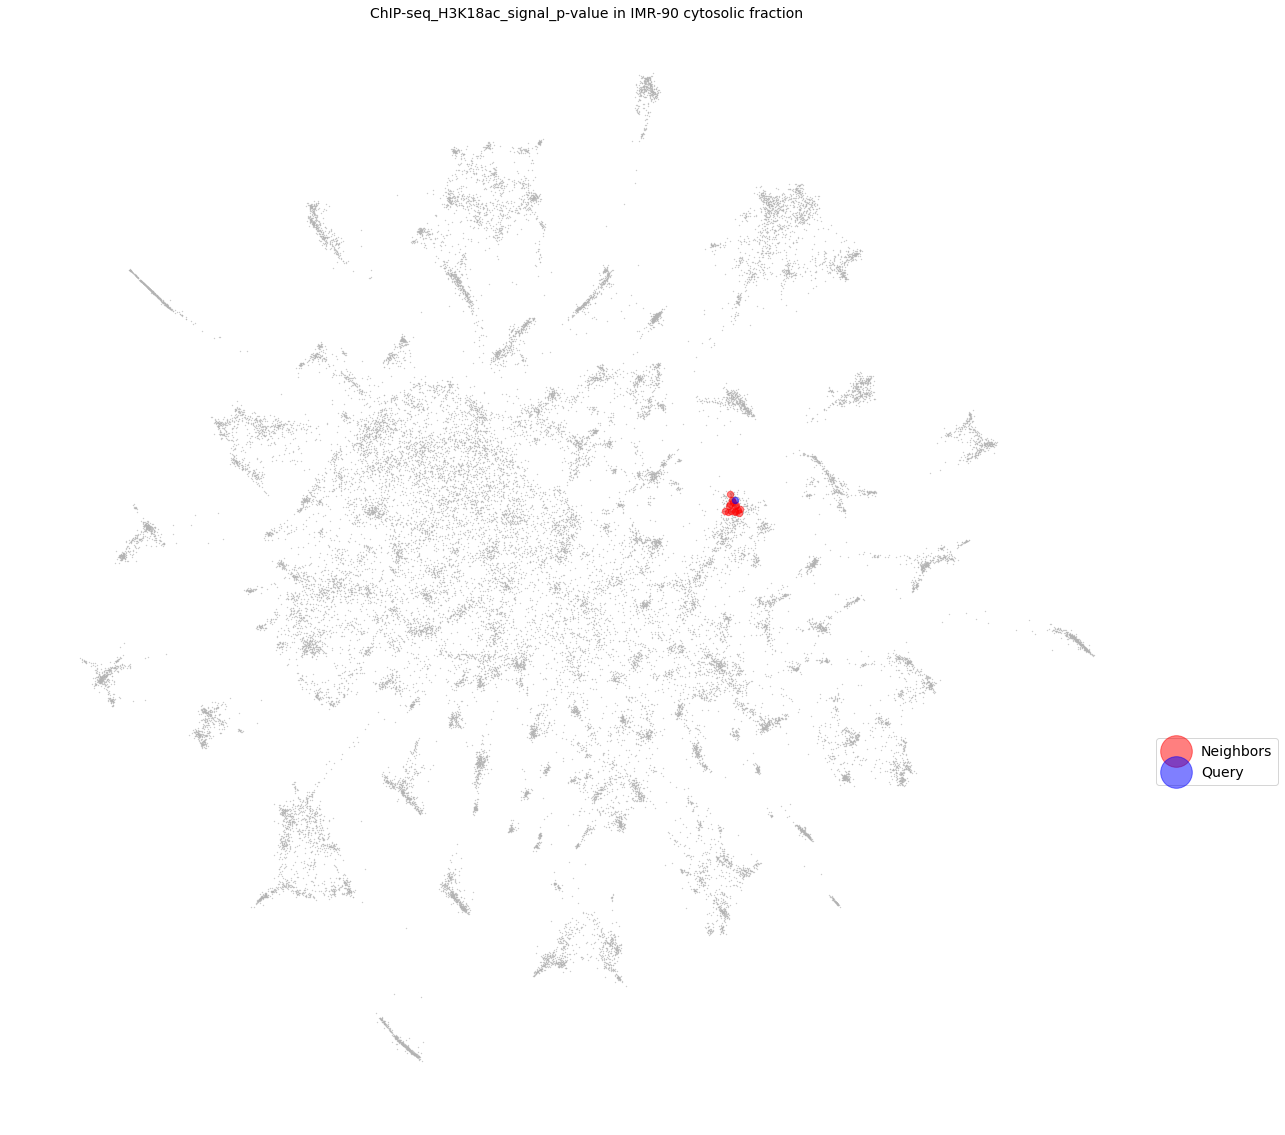

Query: ChIP-seq_ZFP36_signal_p-value in placenta embryo (16 weeks)
Neighbors: (Cell-type ==> Assay)
placenta male embryo (16 weeks)		ChIP-seq_ZFP36_signal_p-value
chorion male embryo (16 weeks)		ChIP-seq_ZFP36_signal_p-value
chorion female embryo (40 weeks)		ChIP-seq_ZFP36_signal_p-value
chorionic villus male embryo (38 weeks)		ChIP-seq_ZFP36_signal_p-value
amnion male embryo (16 weeks)		ChIP-seq_ZFP36_signal_p-value
placental basal plate female embryo (40 weeks)		ChIP-seq_ZFP36_signal_p-value
esophagus squamous epithelium male adult (37 years)		ChIP-seq_ZFP36_signal_p-value
uterus female adult (51 year)		ChIP-seq_ZFP36_signal_p-value
esophagus squamous epithelium female adult (51 year)		ChIP-seq_ZFP36_signal_p-value
placental epithelial cell female newborn and male newborn		ChIP-seq_ZFP36_signal_p-value
heart left ventricle female adult (51 year)		ChIP-seq_ZFP36_signal_p-value
chorionic villus embryo (16 weeks)		ChIP-seq_ZFP36_signal_p-value
chorionic villus female embryo (40 weeks)		

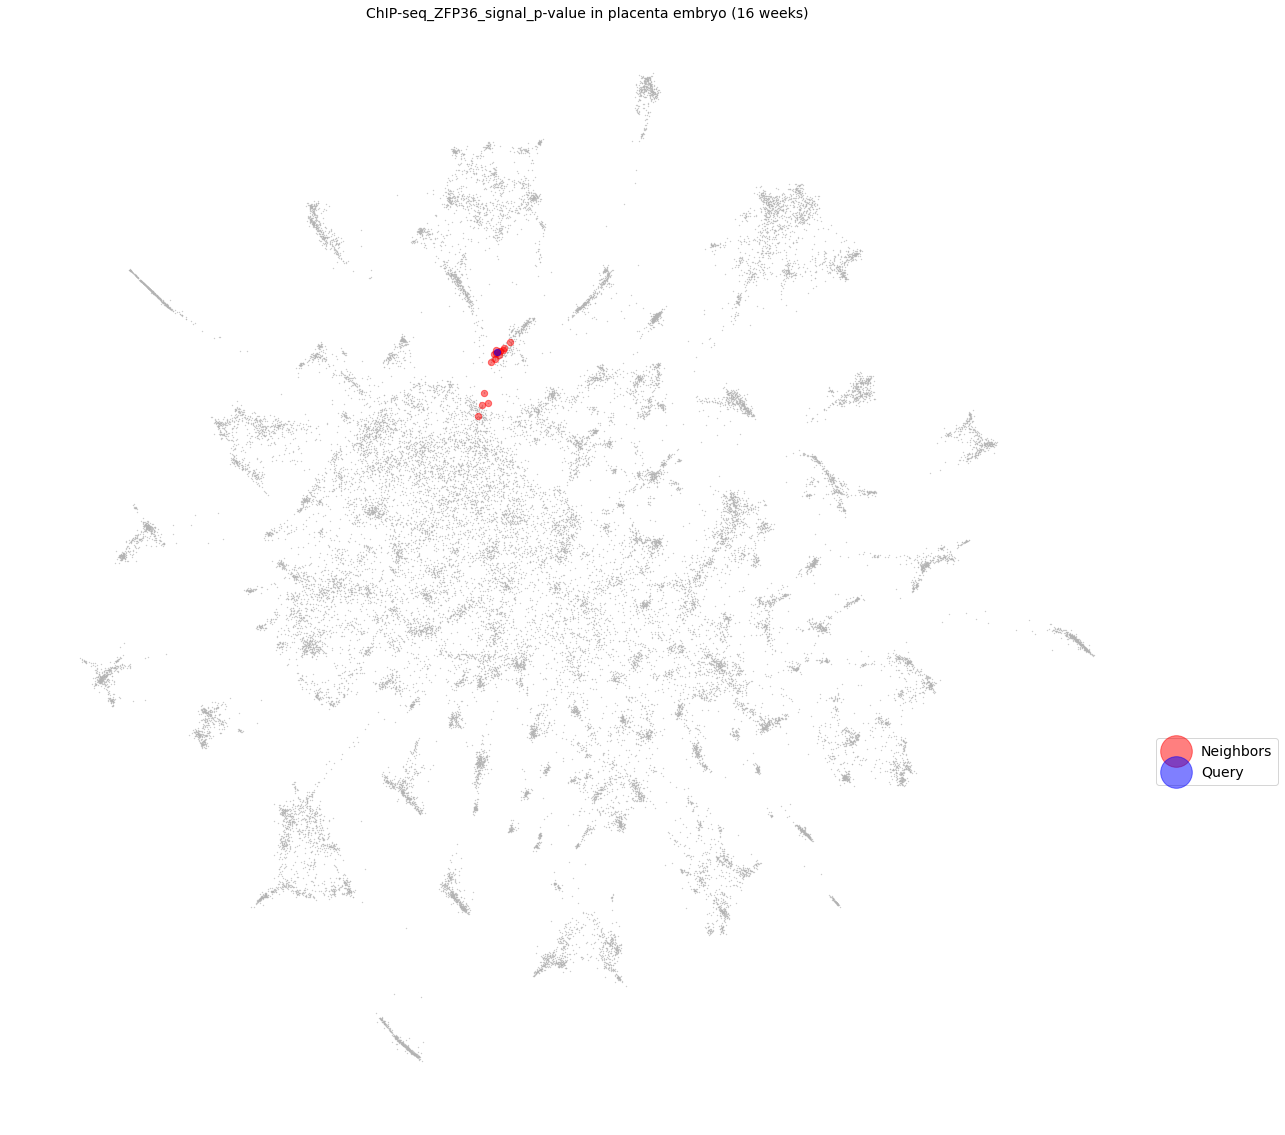

Query: ATAC-seq_signal_p-value in HUES48
Neighbors: (Cell-type ==> Assay)
layer of hippocampus female adult (75 years)		ATAC-seq_signal_p-value
          H9		ATAC-seq_signal_p-value
GM23338 male adult (53 years) originated from GM23248		ATAC-seq_signal_p-value
H9 genetically modified using stable transfection		ATAC-seq_signal_p-value
       HUES6		ATAC-seq_signal_p-value
iPS-18a female adult (48 years)		ATAC-seq_signal_p-value
ectodermal cell originated from embryonic stem cell		ATAC-seq_signal_p-value
H1-hESC nuclear fraction		ATAC-seq_signal_p-value
iPS DF 19.11 male newborn		ATAC-seq_signal_p-value
      NT2/D1		ATAC-seq_signal_p-value
testis male adult (54 years)		ATAC-seq_signal_p-value
iPS-15b female adult (48 years)		ATAC-seq_signal_p-value
muscle of trunk female embryo (115 days)		ATAC-seq_signal_p-value
      HUES64		ATAC-seq_signal_p-value
iPS-20b male adult (55 years)		ATAC-seq_signal_p-value
===========SUMMARY=============
Neighbor Assay			Neighbor Count
ATAC-seq_signal_p-v

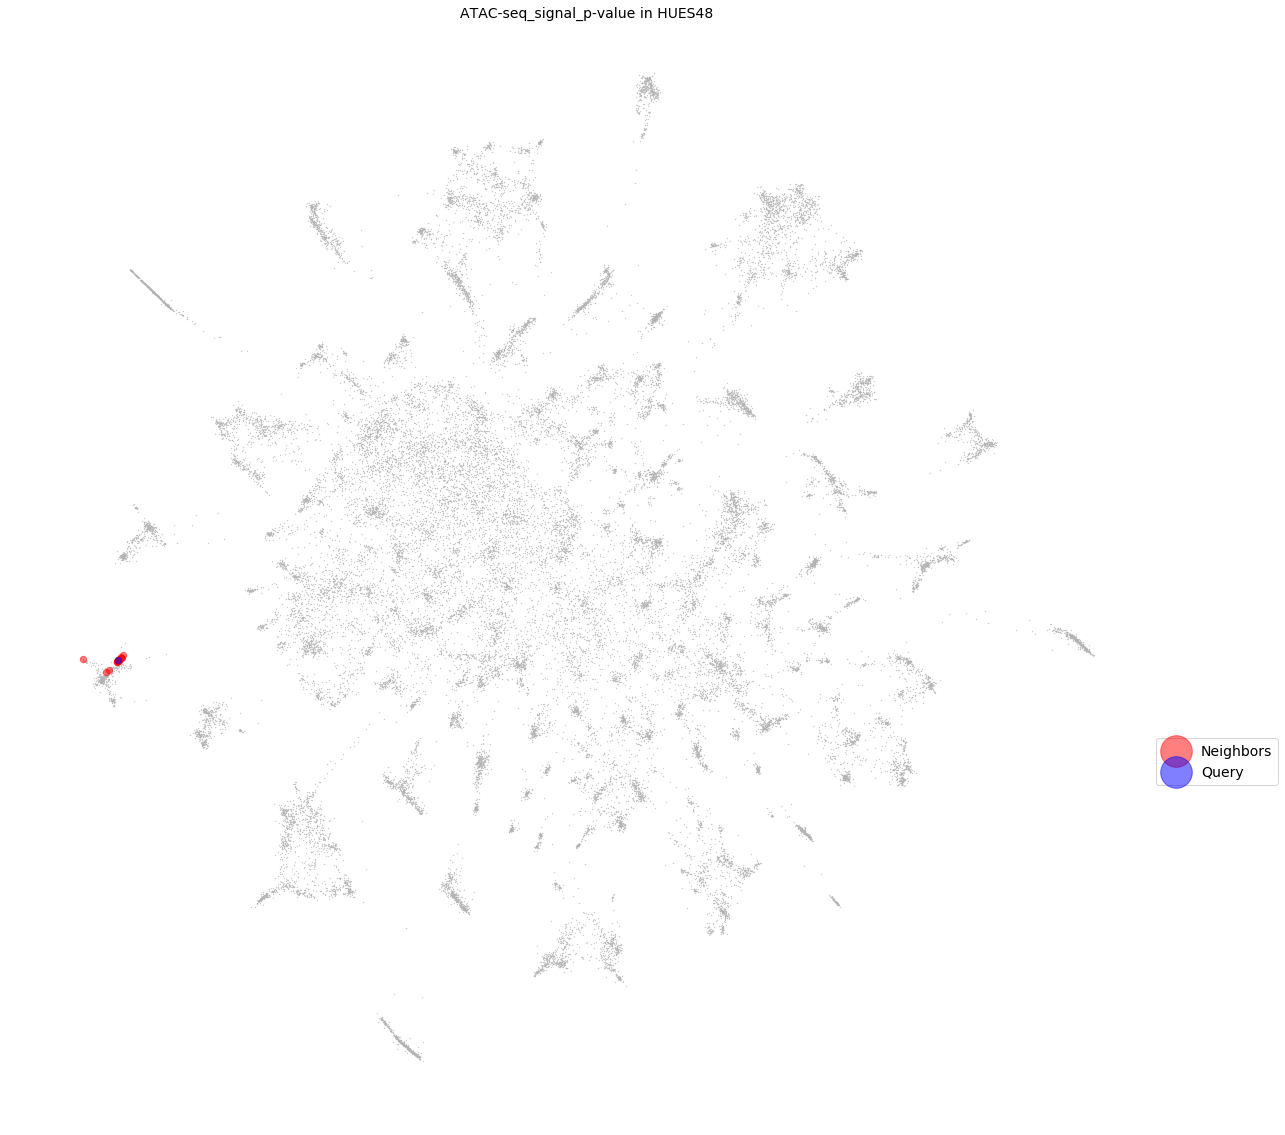

In [21]:
# Test functions above
ex_cases = [123, 236, 901, 21973, 5454, 17777, 33000, 6791] #example cases

ex_cases = [6999, 490, 16632] #example cases
#Histone: 123 vs 6999
#TF : 236 or 21973 vs 490
#RNA: 5454
#ATAC-Seq: 16632, 6791

for query_idx in ex_cases:
    neighbors = get_neighbors(query_idx, expt_embedding, experiments)
    #print('Neighbor Correlations: {}'.format(raw_corr[236, expt_embedding[236] != 0]))
    plot_query_neighbors(query_idx, neighbors, experiments)